<a href="https://colab.research.google.com/github/alexander-toschev/ai-tools/blob/main/fakeml/Practise_FakeAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🎙️ Colab-практика: Определение фейкового аудио на реальном датасете (Fake-or-Real Audio)

# 0. Скачивание и установка библиотек
!pip install librosa scikit-learn tensorflow matplotlib



In [ ]:
# Скачиваем датасет
#!wget https://datashare.ed.ac.uk/bitstream/handle/10283/3336/LA.zip?sequence=3&isAllowed=y -O fake_or_real_audio.zip

/bin/bash: line 1: -O: command not found
--2025-04-28 12:21:20--  https://datashare.ed.ac.uk/bitstream/handle/10283/3336/LA.zip?sequence=3
Resolving datashare.ed.ac.uk (datashare.ed.ac.uk)... 129.215.67.172
Connecting to datashare.ed.ac.uk (datashare.ed.ac.uk)|129.215.67.172|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 7640952520 (7.1G) [application/zip]
Saving to: ‘LA.zip?sequence=3’

LA.zip?sequence=3    45%[========>           ]   3.25G  10.9MB/s    eta 10m 42s

KeyboardInterrupt: 

In [2]:
!gdown https://drive.google.com/uc?id=1eWbJpNrz_-N3QP5fDTFg329N2Fog4Ngk -O audio.zip

Downloading...
From: https://drive.google.com/uc?id=1eWbJpNrz_-N3QP5fDTFg329N2Fog4Ngk
To: /content/audio.zip
100% 10.8M/10.8M [00:00<00:00, 156MB/s]


In [3]:
!unzip -q audio.zip -d /content/audio

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.2794 - loss: 2.2025 - val_accuracy: 0.6000 - val_loss: 28.2599
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7598 - loss: 19.4508 - val_accuracy: 0.6000 - val_loss: 14.6210
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7598 - loss: 10.1750 - val_accuracy: 0.8000 - val_loss: 1.7021
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8799 - loss: 0.5427 - val_accuracy: 0.6000 - val_loss: 2.3628
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8799 - loss: 0.3679 - val_accuracy: 0.6000 - val_loss: 3.0772
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7206 - loss: 0.5856 - val_accuracy: 1.0000 - val_loss: 0.0253
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 3.0445e-05 - val_accuracy: 0.8000 - val_loss: 0.7845
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.8000 - val_l

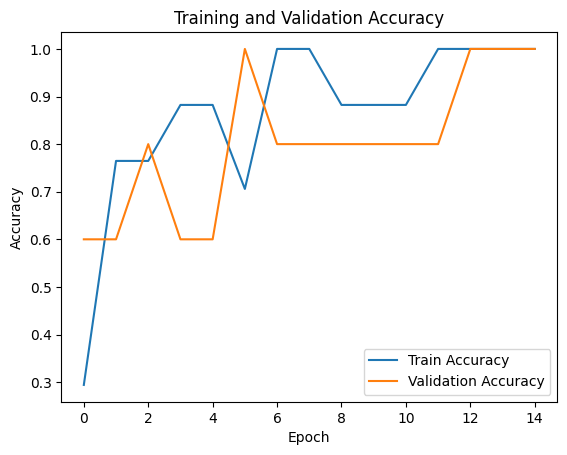

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Prediction (1 = fake, 0 = real): 1
Label
fake    16
real     6
Name: count, dtype: int64


In [6]:


# 1. Импорты
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# 2. Подготовка данных
REAL_DIR = '/content/audio/audio/real'
FAKE_DIR = '/content/audio/audio/fake'

# Функция загрузки и извлечения MFCC признаков

def extract_features(file_path, max_pad_len=100):
    try:
        audio, sample_rate = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        return None

# Загрузка всех данных
features = []
labels = []

for dirpath, label in [(REAL_DIR, 'real'), (FAKE_DIR, 'fake')]:
    for file in os.listdir(dirpath):
        if file.endswith('.wav'):
            data = extract_features(os.path.join(dirpath, file))
            if data is not None:
                features.append(data)
                labels.append(label)

# Преобразуем в массивы
X = np.array(features)
y = np.array(labels)

# Преобразуем метки
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Добавляем ось канала для Conv2D
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# 3. Построение модели
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(40, 100, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Обучение модели
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

# 5. Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# 6. Визуализация обучения
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 7. Прогноз для одного примера
sample_idx = 0
sample = np.expand_dims(X_test[sample_idx], axis=0)
pred = model.predict(sample)
print("Prediction (1 = fake, 0 = real):", round(pred[0][0]))

# 8. Баланс классов
import pandas as pd
labels_df = pd.DataFrame(labels, columns=['Label'])
print(labels_df['Label'].value_counts())


In [7]:
# 🧠 Установка библиотек
!pip install resemblyzer scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:


# 📚 Импорты
from resemblyzer import VoiceEncoder, preprocess_wav
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import os
import librosa
import random

# 🧠 Инициализация эмбеддера
encoder = VoiceEncoder()

# 🎵 Функция получения эмбеддинга из аудиофайла
def get_embedding(file_path):
    wav = preprocess_wav(file_path)
    embed = encoder.embed_utterance(wav)
    return embed

# 📂 Пример структуры папок
# data/real/ - реальные аудио
# data/fake/ - AI-сгенерированные аудио
real_audio_paths = [f"/content/audio/audio/real/{file}" for file in os.listdir("/content/audio/audio/real")]
fake_audio_paths = [f"/content/audio/audio/fake/{file}" for file in os.listdir("/content/audio/audio/fake")]

min_count = min(len(real_audio_paths), len(fake_audio_paths))
real_audio_paths = random.sample(real_audio_paths, min_count)
fake_audio_paths = random.sample(fake_audio_paths, min_count)

# 📈 Сбор данных
X = []
y = []

for path in real_audio_paths:
    X.append(get_embedding(path))
    y.append(0)  # 0 - реальное аудио

for path in fake_audio_paths:
    X.append(get_embedding(path))
    y.append(1)  # 1 - дипфейк аудио

X = np.vstack(X)
y = np.array(y)

# 🔥 Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 Обучение простой модели
model = LogisticRegression()
model.fit(X_train, y_train)

# 📊 Оценка
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 🧪 Предсказание на новом аудиофайле
def predict_audio(file_path):
    embed = get_embedding(file_path).reshape(1, -1)
    prediction = model.predict(embed)
    if prediction[0] == 0:
        print("🎙️ Аудио похоже на реальное.")
    else:
        print("🤖 Аудио похоже на сгенерированное ИИ.")




Loaded the voice encoder model on cpu in 0.06 seconds.
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



In [8]:
# 📂 Пример использования
predict_audio("/content/audio/audio/fake/wholemodel_50sample.wav")

predict_audio("/content/audio/audio/real/ground_truth.wav")

🤖 Аудио похоже на сгенерированное ИИ.
🎙️ Аудио похоже на реальное.
